# Anonymous Hedge - Kamal Sandhu & Abhishek Desai

This notebook take pre-processed data and applies 14 algorithms to it. Features have to be scaled-continous or dummy encoded.
First step is to group the data by adding kmeans of 2, 4, 16, 64 and 128. These are added as additional dummy encoded features.
After that 8 algorithms from sklearn package are applied followed by a deep neural network in Keras. 

Each of the 8 sklearn algorithms go through the following fittings - 
1. Fitted using defaults sklearn parameters
2. Fitted using hand selected paramaters
3. Fitted after finding the best paramteres using Bayesian Hyperparameter optimization
4. Fitted after calibrating the output probabilities using sigmiod function of sklearn's CalibratedClassifierCV class

Last 2 steps are not applied to Keras atm.

After the above steps have been carried out, all the algorithms are used to build 4 meta models. 
1. Stacked classifier using cross-validation and a multi-level Keras preceptron as the meta classfier 
2. Stacked classifier using cross-validation and a multi-level Keras preceptron as the meta classfier. Original features of the
data are also used
3. Ensemble classifier with soft voting to minimize the error
4. Ensemble classifier with hard voting

This notebook is meant as quickstart in the search for an optimal binary classification algorithm. For each of the fittings, multiple parameters are tracked and saved as a json file and a pickle object at the end of the notebook. Predictions are saved as csv files for the positive class for the 4 meta models. I did not re-run the bayesian optimization part before submission cause of time contraint. They were run a day before and the best parameters were recorded.

# Models

1. SGD Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
2. Random Forest Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
3. Gradient Boosting Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
4. MLP Classifier 
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
5. XGB Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
6. Extratrees Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
7. Decision Tress Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
8. Logistic Classifier
       - base
       - hand tuned hyper parameters
       - bayesian hyper paramters
       - bayesian + probability calibration
9. Keras Classifier
       - base
       - hand tuned hyper parameters
10. Stacked CV without features
11. Stacked CV with features
12. Soft voting ensemble
13. Hard voting ensemble

# Metrics
1. Accuracy score
2. f1 score
3. Precision score
4. Recall score
5. Brier Score Loss
6. Confusion Matrix
7. Hamming Loss
8. Jaccard Similarity Score
9. Log Loss
10. Matthews Coef
11. AUC 
12. ROC
13. Time
14. Class predictions
15. Probability predictions on holdout set
16. Probability predictions on test data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import re
import time
import json
import pickle

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, \
GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from skopt import gp_minimize
from skopt.plots import plot_convergence
from mlxtend.classifier import StackingCVClassifier, EnsembleVoteClassifier

%matplotlib inline

/home/metbron/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
train = pd.read_csv("datasource")
predict = pd.read_csv("datasource")

In [5]:
train['which'] = 1
predict['which'] = 0

#data = pd.concat([train.iloc[:numSamples,:],predict.iloc[:numSamples,:]],axis=0)
data = pd.concat([train,predict],axis=0)
data = shuffle(data)

def kmeans(kmeans_num, data):
    for k in kmeans_num:
        print("Doing kmeans of:",k)
        kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', \
                             max_iter=200, batch_size=100, verbose=0, \
                             compute_labels=True, random_state=None, \
                             tol=0.0, max_no_improvement=10, \
                             init_size=None, n_init=3, \
                             reassignment_ratio=0.01)
        kmeans.fit(data.iloc[:,:50])
        y_predict_km = kmeans.predict(data.iloc[:,:50])

        y_predict_km = pd.Series(y_predict_km)
        group = "group"+str(k)
        data[group] = y_predict_km
    return data

kmeans_num = [2,4,16,64,128]
data = kmeans(kmeans_num, data)

('Doing kmeans of:', 2)
('Doing kmeans of:', 4)
('Doing kmeans of:', 16)
('Doing kmeans of:', 64)
('Doing kmeans of:', 128)


In [6]:
columns_group = [c for c in data.columns if re.search('^group.*',c) != None]
data = pd.get_dummies(data, columns = columns_group)

y_train = data[data['which']==1]['target'].values
X_train = data[data['which']==1].drop(['target','which','t_id'],axis=1).values

t_id = data[data['which']==0]['t_id']
predict = data[data['which']==0].drop(['target','which','t_id'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=.15)

In [7]:
_model_metrics = {
    
    "accuracy_score": {
        
        "_sgd":
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        }        
    },
    
    "f1_score": {
        
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "precision_score": {
        
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "recall_score": {
        
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "brier_score_loss": {
    
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        }  
    },
    
    "confusion_matrix": 
     {   
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
     },
    
    "hamming_loss":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        }  
    },
    
    "jaccard_similarity_score": 
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "log_loss":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        }  
    },
    
    "matthews_corrcoef": 
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "roc_auc_score": 
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        }  
    },
    
    "roc_curve":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "calibration_curve":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "predict_proba":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "predict":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "predict_proba_predict":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "predict_predict":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    },
    
    "time":
    {
        "_sgd": 
        {
            "_sgd":[],
            "_sgd_base": [],
            "_sgd_base_sk": [],
            "_sgd_base_sk_cal_cv": []
        },
        "_rfc": 
        {
            "_rfc":[],
            "_rfc_base": [],
            "_rfc_base_sk": [],
            "_rfc_base_sk_cal_cv": []
        },
        "_gbc": 
        {
            "_gbc":[],
            "_gbc_base": [],
            "_gbc_base_sk": [],
            "_gbc_base_sk_cal_cv": []
        },
        "_mlp": 
        {
            "_mlp":[],
            "_mlp_base": [],
            "_mlp_base_sk": [],
            "_mlp_base_sk_cal_cv": []
        },
        "_xgb": 
        {
            "_xgb":[],
            "_xgb_base": [],
            "_xgb_base_sk": [],
            "_xgb_base_sk_cal_cv": []
        },
        "_etc": 
        {
            "_etc":[],
            "_etc_base": [],
            "_etc_base_sk": [],
            "_etc_base_sk_cal_cv": []
        },
        "_dtc": 
        {
            "_dtc":[],
            "_dtc_base": [],
            "_dtc_base_sk": [],
            "_dtc_base_sk_cal_cv": []
        },
        "_lrc": 
        {
            "_lrc":[],
            "_lrc_base": [],
            "_lrc_base_sk": [],
            "_lrc_base_sk_cal_cv": []
        },
        "_krs": 
        {
            "_krs":[],
            "_krs_base": [],
            "_krs_base_sk": [],
            "_krs_base_sk_cal_cv": []
        },
        "_sclf_meta_noF":
        {
            "_sclf_meta_noF" : []
        },
        "_sclf_meta_useF":
        {
            "_sclf_meta_useF" : []
        },
        "_eclf_meta_soft":
        {
            "_eclf_meta_soft" : []
        },
        "_eclf_meta_hard":
        {
            "_eclf_meta_hard" : []
        } 
    }
}

In [103]:
def _compile_model(_model, _model_type, _model_subtype):
    start = time.time()
    _model.fit(X_train, y_train)
    _model_predict = _model.predict(X_test)
    _model_predict_proba = _model.predict_proba(X_test)
    
    _model_predict_predict = _model.predict(predict.values)
    _model_predict_proba_predict = _model.predict_proba(predict.values)
    
    _model_metrics['predict'][_model_type][_model_subtype] = _model_predict
    _model_metrics['predict_proba'][_model_type][_model_subtype] = _model_predict_proba
    
    _model_metrics['predict_predict'][_model_type][_model_subtype] = _model_predict_predict
    _model_metrics['predict_proba_predict'][_model_type][_model_subtype] = _model_predict_proba_predict
    
    _model_metrics['accuracy_score'][_model_type][_model_subtype] = \
    accuracy_score(y_test, _model_predict)
    
    _model_metrics['f1_score'][_model_type][_model_subtype] = \
    f1_score(y_test, _model_predict)
    
    _model_metrics['precision_score'][_model_type][_model_subtype] = \
    precision_score(y_test, _model_predict)
    
    _model_metrics['recall_score'][_model_type][_model_subtype] = \
    recall_score(y_test, _model_predict)

    _model_metrics['brier_score_loss'][_model_type][_model_subtype] = \
    brier_score_loss(y_test, _model_predict_proba[:,1])
    
    # (n_classes,n_classes) array
    _model_metrics['confusion_matrix'][_model_type][_model_subtype] = \
    confusion_matrix(y_test, _model_predict)
    
    _model_metrics['hamming_loss'][_model_type][_model_subtype] = \
    hamming_loss(y_test, _model_predict) 
    
    _model_metrics['jaccard_similarity_score'][_model_type][_model_subtype] = \
    jaccard_similarity_score(y_test, _model_predict)
    
    _model_metrics['log_loss'][_model_type][_model_subtype] = \
    log_loss(y_test, _model_predict_proba)
    
    _model_metrics['matthews_corrcoef'][_model_type][_model_subtype] = \
    matthews_corrcoef(y_test, _model_predict)
    
    _model_metrics['roc_auc_score'][_model_type][_model_subtype] = \
    roc_auc_score(y_test, _model_predict_proba[:,1])
    
    _model_metrics['roc_curve'][_model_type][_model_subtype] = \
    roc_curve(y_test, _model_predict_proba[:,1])  
    
    _model_metrics['calibration_curve'][_model_type][_model_subtype] = \
    roc_curve(y_test, _model_predict_proba[:,1])
    
    _elapsed_time = time.time() - start
    _model_metrics['time'][_model_type][_model_subtype] = _elapsed_time
    _print_metrics(_model_type, _model_subtype)
    
    if re.search('.*meta.*', _model_type) != None:
        predictions_df = _model_predict_proba_predict
        predictions_df = np.concatenate([predictions_df,t_id.reshape(predictions_df.shape[0],1)],axis=1)
        predictions_df = pd.DataFrame(predictions_df, columns=["probability0",
                                                       "probability",
                                                      "t_id"])

        predictions = predictions_df[['probability','t_id']]
        predictions.to_csv(_model_type+'predict.csv')
    
def _print_metrics(_model_type, _model_subtype):
    _dont_print = ['predict','predict_proba','predict_predict','predict_proba_predict','roc_curve','calibration_curve']
    for _score_keys, _name_values in _model_metrics.items():
        if _score_keys not in _dont_print:
            for _models , _models_metrics in _name_values.items():
                if _models == _model_type:
                    for _types_models, _types_scores in _models_metrics.items():
                        if _types_models == _model_subtype:
                            print(_score_keys, ":", _types_scores)

# SGD Classifier

In [9]:
_sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, 
              l1_ratio=0.15, fit_intercept=True, 
              n_iter=5, shuffle=True, verbose=0, 
              epsilon=0.1, n_jobs=1, random_state=None, 
              learning_rate='optimal', eta0=0.0, power_t=0.5, 
              class_weight=None, warm_start=False, average=False)

In [10]:
_compile_model(_sgd, "_sgd", "_sgd")

('f1_score', ':', 0.12379734912198077)
('log_loss', ':', 0.70834222618140197)
('precision_score', ':', 0.51714446318156271)
('time', ':', 2.6494030952453613)
('accuracy_score', ':', 0.50059439352686275)
('roc_auc_score', ':', 0.50702608885442002)
('jaccard_similarity_score', ':', 0.50059439352686275)
('recall_score', ':', 0.070314888413329252)
('brier_score_loss', ':', 0.25736899603007346)
('matthews_corrcoef', ':', 0.0083338494876857398)
('confusion_matrix', ':', array([[12134,   859],
       [12164,   920]]))
('hamming_loss', ':', 0.49940560647313725)


Using hand optimized parameters

In [11]:
_sgd_base = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, 
              l1_ratio=0.15, fit_intercept=True, 
              n_iter=5, shuffle=True, verbose=0, 
              epsilon=0.1, n_jobs=-1, random_state=None, 
              learning_rate='optimal', eta0=0.0, power_t=0.5, 
              class_weight=None, warm_start=False, average=False)

In [12]:
_compile_model(_sgd_base, "_sgd", "_sgd_base")

('f1_score', ':', 0.029400846388002076)
('log_loss', ':', 0.71626194085184813)
('precision_score', ':', 0.51428571428571423)
('time', ':', 2.4375240802764893)
('accuracy_score', ':', 0.49867699505311192)
('roc_auc_score', ':', 0.50363547942460285)
('jaccard_similarity_score', ':', 0.49867699505311192)
('recall_score', ':', 0.015132986854173035)
('brier_score_loss', ':', 0.26110368645101706)
('matthews_corrcoef', ':', 0.0030703799284770425)
('confusion_matrix', ':', array([[12806,   187],
       [12886,   198]]))
('hamming_loss', ':', 0.50132300494688808)


Bayesian Hyperparameter optimization

In [ ]:
def _sgd_base_objective(params):
    penalty, alpha, l1_ratio, n_iter, epsilon, eta0, power_t = params

    _sgd_base.set_params(penalty=penalty, alpha=alpha,
                   l1_ratio=l1_ratio,
                  n_iter=n_iter,
                  epsilon=epsilon,
                  eta0=eta0,
                  power_t=power_t)

    return -np.mean(cross_val_score(_sgd_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_sgd_base_space  = [('l1','l2'),                          # penalty
              (0.00001, 0.01),                         # alpha
          (.05,.5),                                  # l1_ratio
            (10,25),                      # n_iter
                (.01,1),                        # epsilon
            (0.001,0.1),                  # eta0
                (0.3,1)]                   # power_t    
    
_sgd_base_res_gp = gp_minimize(_sgd_base_objective, _sgd_base_space, base_estimator=None, 
            n_calls=150, n_random_starts=3, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

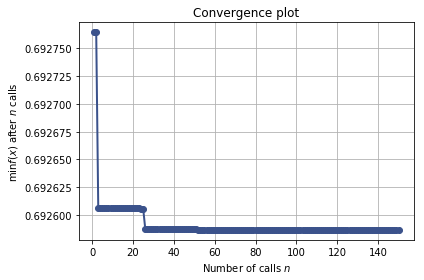

In [15]:
plot_convergence(_sgd_base_res_gp)

Assign the best parameters and check results. Then calibrate and check results again

In [13]:
_sgd_base_sk = SGDClassifier(loss='log', penalty='l2', alpha=0.01, 
              l1_ratio=0.15, fit_intercept=True, 
              n_iter=25, shuffle=True, verbose=0, 
              epsilon=1, n_jobs=-1, random_state=None, 
              learning_rate='optimal', eta0=0.0010000000000000009, power_t=0.29999999999999999, 
              class_weight=None, warm_start=False, average=False)

In [ ]:
_sgd_base_sk.penalty, _sgd_base_sk.alpha, _sgd_base_sk.l1_ratio, _sgd_base_sk.n_iter, \
_sgd_base_sk.epsilon, _sgd_base_sk.eta0, _sgd_base_sk.power_t = _sgd_base_res_gp.x

In [14]:
_compile_model(_sgd_base_sk, "_sgd", "_sgd_base_sk")

('f1_score', ':', 0.55000000000000004)
('log_loss', ':', 0.69247600783762187)
('precision_score', ':', 0.51366410188378875)
('time', ':', 7.016977071762085)
('accuracy_score', ':', 0.51405453081259345)
('roc_auc_score', ':', 0.5213432188623166)
('jaccard_similarity_score', ':', 0.51405453081259345)
('recall_score', ':', 0.59186793029654539)
('brier_score_loss', ':', 0.24966460065952689)
('matthews_corrcoef', ':', 0.027906749452559092)
('confusion_matrix', ':', array([[5661, 7332],
       [5340, 7744]]))
('hamming_loss', ':', 0.48594546918740655)


In [15]:
_sgd_base_sk_cal_cv = CalibratedClassifierCV(base_estimator=_sgd_base_sk, 
                                          method='sigmoid', cv=3)

In [16]:
_compile_model(_sgd_base_sk_cal_cv, "_sgd", "_sgd_base_sk_cal_cv")

('f1_score', ':', 0.5203949867071781)
('log_loss', ':', 0.69249259648726069)
('precision_score', ':', 0.51721274346972668)
('time', ':', 12.611415147781372)
('accuracy_score', ':', 0.5157418414694942)
('roc_auc_score', ':', 0.52123700147267882)
('jaccard_similarity_score', ':', 0.5157418414694942)
('recall_score', ':', 0.52361663099969424)
('brier_score_loss', ':', 0.24967286838798722)
('matthews_corrcoef', ':', 0.031432319007219461)
('confusion_matrix', ':', array([[6598, 6395],
       [6233, 6851]]))
('hamming_loss', ':', 0.4842581585305058)


# Random Forest

In [17]:
_rfc = RandomForestClassifier(n_estimators=10, criterion='gini', 
                              max_depth=None, min_samples_split=2, 
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                              max_features='auto', max_leaf_nodes=None, 
                              min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                              n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                              class_weight=None)

In [18]:
_compile_model(_rfc, "_rfc", "_rfc")

('f1_score', ':', 0.43793728945322619)
('log_loss', ':', 0.82107221334085512)
('precision_score', ':', 0.50347567030784512)
('time', ':', 3.891312837600708)
('accuracy_score', ':', 0.50093952525213792)
('roc_auc_score', ':', 0.50367317345089724)
('jaccard_similarity_score', ':', 0.50093952525213792)
('recall_score', ':', 0.38749617853867319)
('brier_score_loss', ':', 0.27648310771944623)
('matthews_corrcoef', ':', 0.0027456725900337937)
('confusion_matrix', ':', array([[7993, 5000],
       [8014, 5070]]))
('hamming_loss', ':', 0.49906047474786208)


Using hand optimized parameters

In [19]:
_rfc_base = RandomForestClassifier(max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                             max_features='auto', max_leaf_nodes=None, 
                             min_impurity_split=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=-1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)

In [20]:
_compile_model(_rfc_base, "_rfc", "_rfc_base")

('f1_score', ':', 0.43564442136241666)
('log_loss', ':', 0.81445954045056101)
('precision_score', ':', 0.50219517062462582)
('time', ':', 3.9875729084014893)
('accuracy_score', ':', 0.49994247804578745)
('roc_auc_score', ':', 0.50416077226918721)
('jaccard_similarity_score', ':', 0.49994247804578745)
('recall_score', ':', 0.38466829715683276)
('brier_score_loss', ':', 0.27594738658588031)
('matthews_corrcoef', ':', 0.00071161204757765073)
('confusion_matrix', ':', array([[8004, 4989],
       [8051, 5033]]))
('hamming_loss', ':', 0.50005752195421249)


Bayesian Hyperparameter optimization

In [ ]:
def _rfc_base_objective(params):
    max_depth, max_features, min_samples_split, min_samples_leaf = params

    _rfc_base.set_params(max_depth=max_depth,
                   max_features=max_features,
                   min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(_rfc_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_rfc_base_space  = [(1, 5),                           # max_depth
          (1, 50),                  # max_features
          (2, 200),                         # min_samples_split
          (1, 100)]                         # min_samples_leaf

_rfc_base_res_gp = gp_minimize(_rfc_base_objective, 
          _rfc_base_space, base_estimator=None, 
            n_calls=100, n_random_starts=10, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

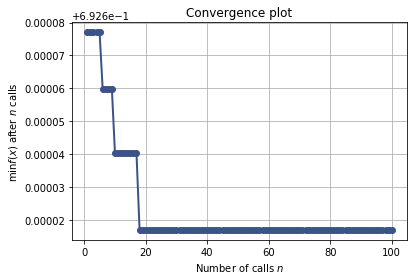

In [29]:
plot_convergence(_rfc_base_res_gp)

Assign the best parameters and check results. Then calibrate and check results again

In [21]:
_rfc_base_sk = RandomForestClassifier(max_depth=4, min_samples_split=153,
                             min_samples_leaf=82, min_weight_fraction_leaf=0.0,
                             max_features=17, max_leaf_nodes=None,
                             min_impurity_split=1e-07, bootstrap=True,
                             oob_score=False, n_jobs=-1, random_state=None,
                             verbose=0, warm_start=False, class_weight=None)

In [22]:
_compile_model(_rfc_base_sk, "_rfc", "_rfc_base_sk")

('f1_score', ':', 0.49051001163677221)
('log_loss', ':', 0.69262803935829376)
('precision_score', ':', 0.51634704739376536)
('time', ':', 2.317744016647339)
('accuracy_score', ':', 0.51309583157571803)
('roc_auc_score', ':', 0.51948178807943124)
('jaccard_similarity_score', ':', 0.51309583157571803)
('recall_score', ':', 0.46713543258942219)
('brier_score_loss', ':', 0.24974046352904469)
('matthews_corrcoef', ':', 0.026626691183034266)
('confusion_matrix', ':', array([[7268, 5725],
       [6972, 6112]]))
('hamming_loss', ':', 0.48690416842428191)


# Gradient Boosting Machine

In [23]:
_gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                           n_estimators=100, subsample=1.0, 
                           criterion='friedman_mse', min_samples_split=2, 
                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_depth=3, min_impurity_split=1e-07, init=None, 
                           random_state=None, max_features=None, verbose=1, 
                           max_leaf_nodes=None, warm_start=False, presort='auto')

In [24]:
_compile_model(_gbc, "_gbc", "_gbc")

      Iter       Train Loss   Remaining Time 
         1           1.3860            5.38m
         2           1.3858            5.27m
         3           1.3856            5.20m
         4           1.3854            5.16m
         5           1.3852            5.13m
         6           1.3850            5.06m
         7           1.3848            5.00m
         8           1.3847            4.89m
         9           1.3846            4.84m
        10           1.3845            4.75m
        20           1.3834            4.14m
        30           1.3828            3.46m
        40           1.3821            2.89m
        50           1.3815            2.38m
        60           1.3810            1.88m
        70           1.3803            1.40m
        80           1.3799           55.83s
        90           1.3793           27.79s
       100           1.3788            0.00s
('f1_score', ':', 0.50833687956980933)
('log_loss', ':', 0.69283924398413299)
('precision_score', '

Using hand optimized parameters

In [25]:
_gbc_base = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                 n_estimators=100, subsample=1.0, 
                                 criterion='friedman_mse', min_samples_split=2, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                 max_depth=3, min_impurity_split=1e-07, init=None, 
                                 random_state=None, max_features=None, verbose=1, 
                                 max_leaf_nodes=None, warm_start=False, presort='auto')

In [26]:
_compile_model(_gbc_base, "_gbc", "_gbc_base")

      Iter       Train Loss   Remaining Time 
         1           1.3860            5.88m
         2           1.3858            5.82m
         3           1.3856            5.76m
         4           1.3854            5.73m
         5           1.3852            5.70m
         6           1.3850            5.67m
         7           1.3848            5.59m
         8           1.3847            5.48m
         9           1.3846            5.41m
        10           1.3845            5.31m
        20           1.3834            4.61m
        30           1.3828            3.86m
        40           1.3821            3.23m
        50           1.3815            2.66m
        60           1.3810            2.11m
        70           1.3803            1.57m
        80           1.3799            1.04m
        90           1.3793           31.11s
       100           1.3788            0.00s
('f1_score', ':', 0.50845097660027083)
('log_loss', ':', 0.69283356021792775)
('precision_score', '

Bayesian Hyperparameter optimization

In [ ]:
def _gbc_base_objective(params):
    max_depth, learning_rate, max_features, min_samples_split,min_samples_leaf = params

    _gbc_base.set_params(max_depth=max_depth,
                         learning_rate=learning_rate,
                         max_features=max_features,
                   min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(_gbc_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_gbc_base_space  = [(1, 5),                           # max_depth
          (10**-5, 10**0, "log-uniform"),   # learning_rate
          (1, 50),                  # max_features
          (2, 100),                         # min_samples_split
          (1, 100)]                         # min_samples_leaf

_gbc_base_res_gp = gp_minimize(_gbc_base_objective, _gbc_base_space, base_estimator=None, 
            n_calls=100, n_random_starts=15, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

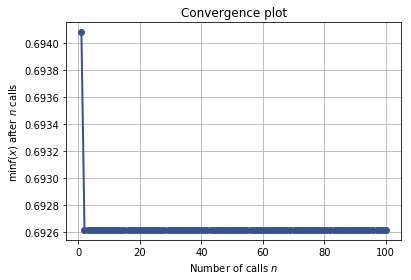

In [12]:
plot_convergence(_gbc_base_res_gp)

Assign the best parameters and check results. Then calibrate and check results again

In [27]:
_gbc_base_sk = GradientBoostingClassifier(loss='deviance', learning_rate=0.031122930246332624,
                                 n_estimators=200, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=62,
                                 min_samples_leaf=14, min_weight_fraction_leaf=0.0,
                                 max_depth=2, min_impurity_split=1e-07, init=None,
                                 random_state=None, max_features=26, verbose=1,
                                 max_leaf_nodes=None, warm_start=False, presort='auto')

In [ ]:
_gbc_base_sk.max_depth, _gbc_base_sk.learning_rate, _gbc_base_sk.max_features, \
_gbc_base_sk.min_samples_split, _gbc_base_sk.min_samples_leaf = _gbc_base_res_gp.x

In [29]:
_compile_model(_gbc_base_sk, "_gbc", "_gbc_base_sk")

      Iter       Train Loss   Remaining Time 
         1           1.3862           55.14s
         2           1.3862           48.69s
         3           1.3862           48.98s
         4           1.3861           47.97s
         5           1.3861           48.26s
         6           1.3861           47.97s
         7           1.3860           47.05s
         8           1.3860           46.48s
         9           1.3859           46.66s
        10           1.3859           46.32s
        20           1.3856           44.03s
        30           1.3853           41.85s
        40           1.3851           39.67s
        50           1.3849           37.14s
        60           1.3848           34.63s
        70           1.3846           32.11s
        80           1.3845           29.61s
        90           1.3844           27.11s
       100           1.3843           24.54s
       200           1.3835            0.00s
('f1_score', ':', 0.50850610346832004)
('log_loss', ':

In [30]:
_gbc_base_sk_cal_cv = CalibratedClassifierCV(base_estimator=_gbc_base_sk, 
                                          method='sigmoid', cv=3)

In [31]:
_compile_model(_gbc_base_sk_cal_cv, "_gbc", "_gbc_base_sk_cal_cv")

      Iter       Train Loss   Remaining Time 
         1           1.3862           35.29s
         2           1.3862           34.14s
         3           1.3861           34.38s
         4           1.3861           34.13s
         5           1.3860           33.68s
         6           1.3860           33.30s
         7           1.3860           32.97s
         8           1.3859           32.68s
         9           1.3859           32.46s
        10           1.3858           32.20s
        20           1.3855           29.91s
        30           1.3852           28.11s
        40           1.3850           26.31s
        50           1.3848           24.68s
        60           1.3846           22.93s
        70           1.3844           21.20s
        80           1.3843           19.48s
        90           1.3841           17.75s
       100           1.3840           16.06s
       200           1.3829            0.00s
      Iter       Train Loss   Remaining Time 
        

# MLP Classifer

In [32]:
_mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', 
                     alpha=0.0001, batch_size='auto', learning_rate='constant', 
                     learning_rate_init=0.001, power_t=0.5, max_iter=200, 
                     shuffle=True, random_state=None, tol=0.0001, verbose=True, 
                     warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                     early_stopping=True, validation_fraction=0.1, beta_1=0.9, 
                     beta_2=0.999, epsilon=1e-08)

In [33]:
_compile_model(_mlp, "_mlp", "_mlp")

Iteration 1, loss = 0.69443926
Validation score: 0.511200
Iteration 2, loss = 0.69274143
Validation score: 0.505380
Iteration 3, loss = 0.69229589
Validation score: 0.511944
Iteration 4, loss = 0.69209999
Validation score: 0.510455
Iteration 5, loss = 0.69168177
Validation score: 0.511538
Iteration 6, loss = 0.69141488
Validation score: 0.506463
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
('f1_score', ':', 0.54905292972207465)
('log_loss', ':', 0.69278772638319264)
('precision_score', ':', 0.5114438361585647)
('time', ':', 76.42213892936707)
('accuracy_score', ':', 0.51156191279671737)
('roc_auc_score', ':', 0.51839234366090836)
('jaccard_similarity_score', ':', 0.51156191279671737)
('recall_score', ':', 0.59263222256190773)
('brier_score_loss', ':', 0.24981996691972239)
('matthews_corrcoef', ':', 0.022860826024548232)
('confusion_matrix', ':', array([[5586, 7407],
       [5330, 7754]]))
('hamming_loss', ':', 0.48843808720328258)


Using hand optimized parameters

In [34]:
_mlp_base = MLPClassifier(hidden_layer_sizes=(220,100,75,25, ), activation='relu',
                     alpha=0.001, batch_size='auto', 
                    learning_rate='adaptive', learning_rate_init=0.001, 
                    power_t=0.5, max_iter=200, shuffle=True, random_state=None, 
                    tol=0.0001, verbose=True, warm_start=True, momentum=0.9, 
                    nesterovs_momentum=True, early_stopping=True, validation_fraction=0.1, 
                    beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [35]:
_compile_model(_mlp_base, "_mlp", "_mlp_base")

Iteration 1, loss = 0.69424340
Validation score: 0.508831
Iteration 2, loss = 0.69364546
Validation score: 0.504771
Iteration 3, loss = 0.69316666
Validation score: 0.509914
Iteration 4, loss = 0.69287854
Validation score: 0.507004
Iteration 5, loss = 0.69263824
Validation score: 0.509305
Iteration 6, loss = 0.69248541
Validation score: 0.508628
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
('f1_score', ':', 0.49005613472333598)
('log_loss', ':', 0.69296070723091197)
('precision_score', ':', 0.51543522267206476)
('time', ':', 44.12280321121216)
('accuracy_score', ':', 0.5122905242167427)
('roc_auc_score', ':', 0.51762519846128374)
('jaccard_similarity_score', ':', 0.5122905242167427)
('recall_score', ':', 0.46705900336288597)
('brier_score_loss', ':', 0.24990607617216304)
('matthews_corrcoef', ':', 0.025000718447478587)
('confusion_matrix', ':', array([[7248, 5745],
       [6973, 6111]]))
('hamming_loss', ':', 0.4877094757832573)


In [36]:
_mlp_base_cal_cv = CalibratedClassifierCV(base_estimator=_mlp_base, 
                                          method='sigmoid', cv=3)

In [37]:
_compile_model(_mlp_base_cal_cv, "_mlp", "_mlp_base_cal_cv")

Iteration 1, loss = 0.69447620
Validation score: 0.514312
Iteration 2, loss = 0.69388919
Validation score: 0.500812
Iteration 3, loss = 0.69360388
Validation score: 0.509338
Iteration 4, loss = 0.69312564
Validation score: 0.516545
Iteration 5, loss = 0.69285441
Validation score: 0.506192
Iteration 6, loss = 0.69254989
Validation score: 0.512180
Iteration 7, loss = 0.69237708
Validation score: 0.514819
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.69437601
Validation score: 0.507816
Iteration 2, loss = 0.69386360
Validation score: 0.506699
Iteration 3, loss = 0.69317708
Validation score: 0.501827
Iteration 4, loss = 0.69287542
Validation score: 0.503959
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.69441256
Validation score: 0.494722
Iteration 2, loss = 0.69359129
Validation score: 0.513601
Iteration 3, loss = 0.69316353
Validation score: 0.508425


Bayesian Hyperparameter optimization

In [ ]:
# This one does not work
def _mlp_base_objective(params):
    activation, alpha, learning_rate_init, max_iter, momentum, learning_rate = params

    _mlp_base.set_params(activation=activation,
                   alpha=alpha, 
                   learning_rate_init=learning_rate_init,
                   max_iter=max_iter,momentum=momentum,learning_rate=learning_rate)

    return -np.mean(cross_val_score(_mlp_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

 
_mlp_base_space = [                          
              ("relu", "tanh"),                         # activation 
                (.05,.001),                    # alpha
                  (0.01,0.001),                             # learning_rate_init
                   (10,200),                          # max_iter
                     (0.65,1),                 # momentum
                        (0.0001,0.1)         # learning rate
            ]
_mlp_base_res_gp = gp_minimize(_mlp_base_objective, 
            _mlp_base_space, base_estimator=None, 
            n_calls=10, n_random_starts=10, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

# XGB Classifier

In [38]:
_xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, 
                     silent=False, objective='binary:logistic', nthread=-1, 
                     gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
                     colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                     scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

In [39]:
_compile_model(_xgb, "_xgb", "_xgb")

('f1_score', ':', 0.51062516872999342)
('log_loss', ':', 0.69264608884340473)
('precision_score', ':', 0.51537563254184504)
('time', ':', 9.930334091186523)
('accuracy_score', ':', 0.51340261533151821)
('roc_auc_score', ':', 0.51980941669717839)
('jaccard_similarity_score', ':', 0.51340261533151821)
('recall_score', ':', 0.50596147966982574)
('brier_score_loss', ':', 0.2497474741618862)
('matthews_corrcoef', ':', 0.026860141216428091)
('confusion_matrix', ':', array([[6768, 6225],
       [6464, 6620]]))
('hamming_loss', ':', 0.48659738466848179)


Using hand optimized parameters

In [40]:
_xgb_base = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, 
                     silent=False, objective='binary:logistic', nthread=-1, 
                     gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
                     colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
                     reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, 
                     missing=None)

In [41]:
_compile_model(_xgb_base, "_xgb", "_xgb_base")

('f1_score', ':', 0.51062516872999342)
('log_loss', ':', 0.69264608884340473)
('precision_score', ':', 0.51537563254184504)
('time', ':', 9.641983985900879)
('accuracy_score', ':', 0.51340261533151821)
('roc_auc_score', ':', 0.51980941669717839)
('jaccard_similarity_score', ':', 0.51340261533151821)
('recall_score', ':', 0.50596147966982574)
('brier_score_loss', ':', 0.2497474741618862)
('matthews_corrcoef', ':', 0.026860141216428091)
('confusion_matrix', ':', array([[6768, 6225],
       [6464, 6620]]))
('hamming_loss', ':', 0.48659738466848179)


Bayesian Hyperparameter optimization (number of iteration are set to minimum cause of cost complexity)

In [ ]:
def _xgb_base_objective(params):
    max_depth, learning_rate, colsample_bylevel,reg_lambda,n_estimators = params

    _xgb_base.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   #max_features=max_features,
                   colsample_bylevel=colsample_bylevel,
                  reg_lambda=reg_lambda,
                        n_estimators=n_estimators)

    return -np.mean(cross_val_score(_xgb_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_xgb_base_space  = [(2, 6),                           # max_depth
          (10**-5, 10**0),   # learning_rate
          (.2, .4),                         # colsample_bylevel
          (1, 3),                     # reg_lambda
            (100,250)]                         # n_estimators

_xgb_base_res_gp = gp_minimize(_xgb_base_objective,_xgb_base_space, base_estimator=None, 
            n_calls=20, n_random_starts=4, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

Assign the best parameters and check results. Then calibrate and check results again

In [42]:
_xgb_base_sk = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [ ]:
_xgb_base_sk.max_depth, _xgb_base_sk.learning_rate, _xgb_base_sk.colsample_bylevel, \
_xgb_base_sk.reg_lambda, _xgb_base_sk.n_estimators = _xgb_base_res_gp.x

In [43]:
_compile_model(_xgb_base_sk, "_xgb", "_xgb_base_sk")

('f1_score', ':', 0.50350959288722508)
('log_loss', ':', 0.6925889871788522)
('precision_score', ':', 0.51401273885350318)
('time', ':', 18.575144052505493)
('accuracy_score', ':', 0.51175365264409245)
('roc_auc_score', ':', 0.51873019578329016)
('jaccard_similarity_score', ':', 0.51175365264409245)
('recall_score', ':', 0.49342708651788442)
('brier_score_loss', ':', 0.2497211316696234)
('matthews_corrcoef', ':', 0.023651448904398728)
('confusion_matrix', ':', array([[6889, 6104],
       [6628, 6456]]))
('hamming_loss', ':', 0.4882463473559075)


In [44]:
_xgb_base_sk_cal_cv = CalibratedClassifierCV(base_estimator=_xgb_base_sk, 
                                          method='sigmoid', cv=3)

In [45]:
_compile_model(_xgb_base_sk_cal_cv, "_xgb", "_xgb_base_sk_cal_cv")

('f1_score', ':', 0.50076756543987411)
('log_loss', ':', 0.6926099004211711)
('precision_score', ':', 0.51627302978654332)
('time', ':', 41.3513388633728)
('accuracy_score', ':', 0.51363270314836829)
('roc_auc_score', ':', 0.52051721204063905)
('jaccard_similarity_score', ':', 0.51363270314836829)
('recall_score', ':', 0.48616630999694282)
('brier_score_loss', ':', 0.24973147055899481)
('matthews_corrcoef', ':', 0.027499276050210839)
('confusion_matrix', ':', array([[7033, 5960],
       [6723, 6361]]))
('hamming_loss', ':', 0.48636729685163171)


# ExtraTreesClassifier

In [46]:
_etc = ExtraTreesClassifier(n_estimators=10, criterion='gini', 
                            max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, 
                            min_impurity_split=1e-07, bootstrap=False, 
                            oob_score=False, n_jobs=-1, random_state=None, 
                            verbose=1, warm_start=False, class_weight=None)

In [47]:
_compile_model(_etc, "_etc", "_etc")

[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished


('f1_score', ':', 0.4404602853079343)
('log_loss', ':', 0.79582315812964355)
('precision_score', ':', 0.50499061172052573)
('time', ':', 3.6685009002685547)
('accuracy_score', ':', 0.50212831230586341)
('roc_auc_score', ':', 0.50403677256970403)
('jaccard_similarity_score', ':', 0.50212831230586341)
('recall_score', ':', 0.39055334760012228)
('brier_score_loss', ':', 0.27630478966138738)
('matthews_corrcoef', ':', 0.0051692932295796567)
('confusion_matrix', ':', array([[7984, 5009],
       [7974, 5110]]))
('hamming_loss', ':', 0.49787168769413659)


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished


Using hand optimized parameters

In [48]:
_etc_base = ExtraTreesClassifier(n_estimators=100,
                            max_depth=6, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features='auto', max_leaf_nodes=None, 
                            min_impurity_split=1e-07, bootstrap=False, 
                            oob_score=False, n_jobs=-1, random_state=None, 
                            verbose=0, warm_start=True, class_weight=None)

In [49]:
_compile_model(_etc_base, "_etc", "_etc_base")

('f1_score', ':', 0.52315706035556575)
('log_loss', ':', 0.69267258092679329)
('precision_score', ':', 0.51681706316652998)
('time', ':', 3.6935548782348633)
('accuracy_score', ':', 0.51555010162211912)
('roc_auc_score', ':', 0.52070364394175706)
('jaccard_similarity_score', ':', 0.51555010162211912)
('recall_score', ':', 0.52965453989605626)
('brier_score_loss', ':', 0.24976275632780789)
('matthews_corrcoef', ':', 0.031013753935904272)
('confusion_matrix', ':', array([[6514, 6479],
       [6154, 6930]]))
('hamming_loss', ':', 0.48444989837788088)


Bayesian Hyperparameter optimization

In [13]:
def _etc_base_objective(params):
    max_depth, bootstrap, max_features, min_samples_split, \
    min_samples_leaf, n_estimators = params

    _etc_base.set_params(max_depth=max_depth,
                   bootstrap=bootstrap,max_features=max_features,
                   min_samples_leaf=min_samples_leaf,
                   min_samples_split=min_samples_split,
                  n_estimators=n_estimators)

    return -np.mean(cross_val_score(_etc_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_etc_base_space  = [(1, 5),                           # max_depth
          ('True', 'False'),   # bootstrap
          (1, 50),                  # max_features
          (2, 100),                         # min_samples_split
          (1, 100),                         # min_samples_leaf
             (100,400)]                         # n_estimators
                           
_etc_base_res_gp = gp_minimize(_etc_base_objective, 
              _etc_base_space, base_estimator=None, 
            n_calls=50, n_random_starts=5, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 63.6701
Function value obtained: 0.6927
Current minimum: 0.6927
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.5972
Function value obtained: 0.6930
Current minimum: 0.6927
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.0051
Function value obtained: 0.6929
Current minimum: 0.6927
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 45.9290
Function value obtained: 0.6928
Current minimum: 0.6927
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.2253
Function value obtained: 0.6929
Current minimum: 0.6927
Iteration No: 6 started. Searc

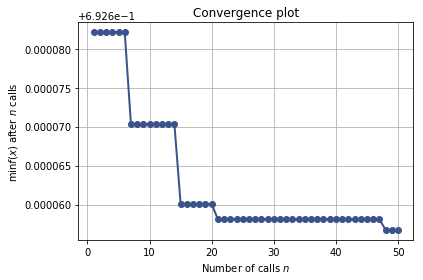

In [28]:
plot_convergence(_etc_base_res_gp)

Assign the best parameters and check results. Then calibrate and check results again

In [50]:
_etc_base_sk = ExtraTreesClassifier(n_estimators=326, criterion='entropy',
                            max_depth=5, min_samples_split=2,
                            min_samples_leaf=100, min_weight_fraction_leaf=0.0,
                            max_features=50, max_leaf_nodes=None,
                            min_impurity_split=1e-07, bootstrap=True,
                            oob_score=False, n_jobs=-1, random_state=None,
                            verbose=1, warm_start=False, class_weight=None)

In [ ]:
_etc_base_sk.max_depth,_etc_base_sk.bootstrap,_etc_base_sk.max_features, \
_etc_base_sk.min_samples_split,_etc_base_sk.min_samples_leaf, \
_etc_base_sk.n_estimators = _etc_base_res_gp.x

In [51]:
_compile_model(_etc_base_sk, "_etc", "_etc_base_sk")

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    5.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished


('f1_score', ':', 0.51956074124914198)
('log_loss', ':', 0.69258359248342383)
('precision_score', ':', 0.51841424440724393)
('time', ':', 10.148895025253296)
('accuracy_score', ':', 0.5168155846147946)
('roc_auc_score', ':', 0.52148150088012724)
('jaccard_similarity_score', ':', 0.5168155846147946)
('recall_score', ':', 0.52071232039131765)
('brier_score_loss', ':', 0.24971829601736048)
('matthews_corrcoef', ':', 0.033604731545535553)
('confusion_matrix', ':', array([[6664, 6329],
       [6271, 6813]]))
('hamming_loss', ':', 0.48318441538520535)


In [52]:
_etc_base_sk_cal_cv = CalibratedClassifierCV(base_estimator=_etc_base_sk, 
                                          method='sigmoid', cv=3)

In [53]:
_compile_model(_etc_base_sk_cal_cv, "_etc", "_etc_base_sk_cal_cv")

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    4.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    4.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    4.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parall

('f1_score', ':', 0.5221379833206975)
('log_loss', ':', 0.69244403883619932)
('precision_score', ':', 0.51797533092659442)
('time', ':', 26.22573208808899)
('accuracy_score', ':', 0.51658549679794452)
('roc_auc_score', ':', 0.52179425306333971)
('jaccard_similarity_score', ':', 0.51658549679794452)
('recall_score', ':', 0.5263680831549985)
('brier_score_loss', ':', 0.24964865552864746)
('matthews_corrcoef', ':', 0.03310873438825726)
('confusion_matrix', ':', array([[6584, 6409],
       [6197, 6887]]))
('hamming_loss', ':', 0.48341450320205548)


# DecisionTreeClassifier

In [54]:
_dtc = DecisionTreeClassifier(criterion='gini', splitter='best', 
                              max_depth=None, min_samples_split=2, 
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                              max_features=None, random_state=None, max_leaf_nodes=None, 
                              min_impurity_split=1e-07, class_weight=None, presort=False)

In [55]:
_compile_model(_dtc, "_dtc", "_dtc")

('f1_score', ':', 0.5000767224182906)
('log_loss', ':', 17.260778999826513)
('precision_score', ':', 0.50200246457178066)
('time', ':', 40.29994297027588)
('accuracy_score', ':', 0.50024926180158757)
('roc_auc_score', ':', 0.50025655820175297)
('jaccard_similarity_score', ':', 0.50024926180158757)
('recall_score', ':', 0.49816569856313053)
('brier_score_loss', ':', 0.49975073819841237)
('matthews_corrcoef', ':', 0.00051311776175756241)
('confusion_matrix', ':', array([[6527, 6466],
       [6566, 6518]]))
('hamming_loss', ':', 0.49975073819841237)


Using hand optimized parameters

In [56]:
_dtc_base = DecisionTreeClassifier(splitter='best', 
                              max_depth=None, min_samples_split=2, 
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                              max_features=None, random_state=None, 
                              max_leaf_nodes=None, min_impurity_split=1e-07, 
                              class_weight=None, presort=False)

In [58]:
_compile_model(_dtc_base, "_dtc", "_dtc_base")

('f1_score', ':', 0.49819494584837543)
('log_loss', ':', 17.305811725884993)
('precision_score', ':', 0.50069476609541452)
('time', ':', 40.67822790145874)
('accuracy_score', ':', 0.49894543083943704)
('roc_auc_score', ':', 0.49895672605781682)
('jaccard_similarity_score', ':', 0.49894543083943704)
('recall_score', ':', 0.49571996331397128)
('brier_score_loss', ':', 0.5010545691605629)
('matthews_corrcoef', ':', -0.0020865789990979619)
('confusion_matrix', ':', array([[6525, 6468],
       [6598, 6486]]))
('hamming_loss', ':', 0.5010545691605629)


Bayesian Hyperparameter optimization

In [33]:
def _dtc_base_objective(params):
    max_depth, max_features,min_weight_fraction_leaf,max_leaf_nodes, \
    min_samples_split = params

    _dtc_base.set_params(max_depth=max_depth,
                   max_features=max_features,
                   min_weight_fraction_leaf=min_weight_fraction_leaf,
                   max_leaf_nodes=max_leaf_nodes,
                   min_samples_split=min_samples_split)

    return -np.mean(cross_val_score(_dtc_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_dtc_base_space  = [(1, 5),                           # max_depth
          (1, 50),                  # max_features
          (0, .25),                         # min_weight_fraction_leaf
          (2, 150),                         # max_leaf_nodes
            (2,50)]                        #min_samples_split

_dtc_base_res_gp = gp_minimize(_dtc_base_objective, _dtc_base_space, base_estimator=None, 
            n_calls=75, n_random_starts=8, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.9758
Function value obtained: 0.7018
Current minimum: 0.7018
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.8530
Function value obtained: 0.6930
Current minimum: 0.6930
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.2146
Function value obtained: 0.6956
Current minimum: 0.6930
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.4938
Function value obtained: 0.6928
Current minimum: 0.6928
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.8273
Function value obtained: 0.6970
Current minimum: 0.6928
Iteration No: 6 started. Evaluating

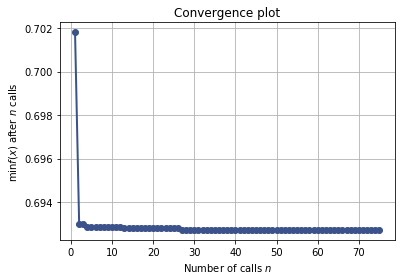

In [34]:
plot_convergence(_dtc_base_res_gp)

Assign the best parameters and check results. Then calibrate and check results again

In [59]:
_dtc_base_sk = DecisionTreeClassifier(class_weight=None, criterion='gini',
                              max_depth=1, max_features=50, max_leaf_nodes=58,
                              min_impurity_split=1e-07, min_samples_leaf=1,
                              min_samples_split=2, min_weight_fraction_leaf=0.0,
                              presort=False, random_state=None, splitter='best')

In [ ]:
_dtc_base_sk.max_depth,_dtc_base_sk.max_features, \
_dtc_base_sk.min_weight_fraction_leaf,_dtc_base_sk.max_leaf_nodes, \
_dtc_base_sk.min_samples_split = _dtc_base_res_gp.x

In [60]:
_compile_model(_dtc_base_sk, "_dtc", "_dtc_base_sk")

('f1_score', ':', 0.37697659709044906)
('log_loss', ':', 0.69290089997287041)
('precision_score', ':', 0.51867719908957022)
('time', ':', 2.103992223739624)
('accuracy_score', ':', 0.5089542508724163)
('roc_auc_score', ':', 0.51173592449881822)
('jaccard_similarity_score', ':', 0.5089542508724163)
('recall_score', ':', 0.29608682360134514)
('brier_score_loss', ':', 0.24987683294825727)
('matthews_corrcoef', ':', 0.021455156201374555)
('confusion_matrix', ':', array([[9398, 3595],
       [9210, 3874]]))
('hamming_loss', ':', 0.4910457491275837)


In [61]:
_dtc_base_sk_cal_cv = CalibratedClassifierCV(base_estimator=_dtc_base_sk, 
                                          method='sigmoid', cv=3)

In [62]:
_compile_model(_dtc_base_sk_cal_cv, "_dtc", "_dtc_base_sk_cal_cv")

('f1_score', ':', 0.46959218743451109)
('log_loss', ':', 0.69271220843346282)
('precision_score', ':', 0.51990719257540607)
('time', ':', 5.092869997024536)
('accuracy_score', ':', 0.5147064462936688)
('roc_auc_score', ':', 0.5198363195731549)
('jaccard_similarity_score', ':', 0.5147064462936688)
('recall_score', ':', 0.4281565270559462)
('brier_score_loss', ':', 0.24978255440505226)
('matthews_corrcoef', ':', 0.030481719302182499)
('confusion_matrix', ':', array([[7820, 5173],
       [7482, 5602]]))
('hamming_loss', ':', 0.48529355370633126)


# LogisticRegression

In [63]:
_lrc = LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                          C=1.0, fit_intercept=True, intercept_scaling=1, 
                          class_weight=None, random_state=None, solver='liblinear', 
                          max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

In [64]:
_compile_model(_lrc, "_lrc", "_lrc")

('f1_score', ':', 0.51658605324294471)
('log_loss', ':', 0.69313698274688396)
('precision_score', ':', 0.51484096257496392)
('time', ':', 9.899363994598389)
('accuracy_score', ':', 0.51324922345361812)
('roc_auc_score', ':', 0.51632533690565396)
('jaccard_similarity_score', ':', 0.51324922345361812)
('recall_score', ':', 0.51834301436869457)
('brier_score_loss', ':', 0.24999325306476919)
('matthews_corrcoef', ':', 0.026464018109433822)
('confusion_matrix', ':', array([[6602, 6391],
       [6302, 6782]]))
('hamming_loss', ':', 0.48675077654638188)


Using hand optimized parameters

In [65]:
_lrc_base = LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                           C=1.0, fit_intercept=True, intercept_scaling=1, 
                           class_weight=None, random_state=None, 
                           solver='liblinear', max_iter=100, 
                           multi_class='ovr', verbose=0, 
                           warm_start=False, n_jobs=-1)

In [66]:
_compile_model(_lrc_base, "_lrc", "_lrc_base")

('f1_score', ':', 0.51658605324294471)
('log_loss', ':', 0.69313698274688396)
('precision_score', ':', 0.51484096257496392)
('time', ':', 10.069700002670288)
('accuracy_score', ':', 0.51324922345361812)
('roc_auc_score', ':', 0.51632533690565396)
('jaccard_similarity_score', ':', 0.51324922345361812)
('recall_score', ':', 0.51834301436869457)
('brier_score_loss', ':', 0.24999325306476919)
('matthews_corrcoef', ':', 0.026464018109433822)
('confusion_matrix', ':', array([[6602, 6391],
       [6302, 6782]]))
('hamming_loss', ':', 0.48675077654638188)


Bayesian Hyperparameter optimization

In [45]:
def _lrc_base_objective(params):
    tol, C, max_iter = params

    _lrc_base.set_params(tol=tol,
                   C=C,
                  max_iter=max_iter)

    return -np.mean(cross_val_score(_lrc_base, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_log_loss"))

_lrc_base_space  = [(1, 5),                           # tol
          (1, 100),                        # C 
                  (50,250)]                          #max_iter

_lrc_base_res_gp = gp_minimize(_lrc_base_objective, 
              _lrc_base_space, base_estimator=None, 
            n_calls=75, n_random_starts=10, acq_func='gp_hedge', 
            acq_optimizer='lbfgs', x0=None, y0=None, random_state=None, 
            verbose=True, callback=None, n_points=1000, 
            n_restarts_optimizer=5, xi=0.01, kappa=1.96, 
            noise='gaussian', n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.5916
Function value obtained: 0.6931
Current minimum: 0.6931
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.1844
Function value obtained: 0.6935
Current minimum: 0.6931
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.6750
Function value obtained: 0.6931
Current minimum: 0.6931
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.6572
Function value obtained: 0.6931
Current minimum: 0.6931
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.5521
Function value obtained: 0.6931
Current minimum: 0.6931
Iteration No: 6 started. Evaluating

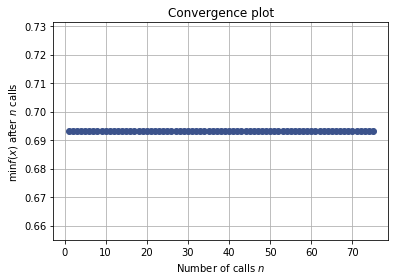

In [46]:
plot_convergence(_lrc_base_res_gp)

Assign the best parameters and check results. Then calibrate and check results again

In [67]:
_lrc_base_sk = LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                           C=51.0, fit_intercept=True, intercept_scaling=1, 
                           class_weight=None, random_state=None, 
                           solver='liblinear', max_iter=69, 
                           multi_class='ovr', verbose=0, 
                           warm_start=False, n_jobs=-1)

In [ ]:
_lrc_base_sk.tol ,_lrc_base_sk.C ,_lrc_base_sk.max_iter = _lrc_base_res_gp.x

In [69]:
_compile_model(_lrc_base_sk, "_lrc", "_lrc_base_sk")

('f1_score', ':', 0.51687104882321566)
('log_loss', ':', 0.69314166562958257)
('precision_score', ':', 0.51510551085471379)
('time', ':', 10.01988697052002)
('accuracy_score', ':', 0.51351765923994319)
('roc_auc_score', ':', 0.51632930160192791)
('jaccard_similarity_score', ':', 0.51351765923994319)
('recall_score', ':', 0.51864873127483946)
('brier_score_loss', ':', 0.24999556298881076)
('matthews_corrcoef', ':', 0.027000675302886749)
('confusion_matrix', ':', array([[6605, 6388],
       [6298, 6786]]))
('hamming_loss', ':', 0.48648234076005675)


In [70]:
_lrc_base_sk_cal_cv = CalibratedClassifierCV(base_estimator=_lrc_base_sk, 
                                          method='sigmoid', cv=3)

In [71]:
_compile_model(_lrc_base_sk_cal_cv, "_lrc", "_lrc_base_sk_cal_cv")

('f1_score', ':', 0.51160817585807949)
('log_loss', ':', 0.6928333084241699)
('precision_score', ':', 0.51634750116767869)
('time', ':', 20.3553729057312)
('accuracy_score', ':', 0.51436131456839362)
('roc_auc_score', ':', 0.5165454893132847)
('jaccard_similarity_score', ':', 0.51436131456839362)
('recall_score', ':', 0.5069550596147967)
('brier_score_loss', ':', 0.24984308023026941)
('matthews_corrcoef', ':', 0.028777462198438561)
('confusion_matrix', ':', array([[6780, 6213],
       [6451, 6633]]))
('hamming_loss', ':', 0.48563868543160638)


In [72]:
with open("_model_metrics_f8.pkl", 'wb') as file:
    pickle.dump(_model_metrics,file)
f8 = pd.DataFrame(_model_metrics)
f8.to_json('_model_metrics_f8.json')

# Keras Classifier

In [73]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(220, input_dim=input_dim))
    model.add(Dense(100))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['binary_crossentropy'])
    return model

input_dim = X_train.shape[1]
_krs = KerasClassifier(build_fn=create_model, verbose=0)

In [74]:
_compile_model(_krs, "_krs", "_krs")

('f1_score', ':', 0.40353241924238903)
('log_loss', ':', 0.69319647084525171)
('precision_score', ':', 0.51488554145415732)
('time', ':', 75.50204396247864)
('accuracy_score', ':', 0.5078805077271159)
('roc_auc_score', ':', 0.50944304182039279)
('jaccard_similarity_score', ':', 0.5078805077271159)
('recall_score', ':', 0.33177927239376337)
('brier_score_loss', ':', 0.2500244810642952)
('matthews_corrcoef', ':', 0.018166356811131053)
('confusion_matrix', ':', array([[8903, 4090],
       [8743, 4341]]))
('hamming_loss', ':', 0.49211949227288415)


Using hand optimized parameters

In [77]:
def create_model(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(220, input_dim=input_dim, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(100, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(25, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(8, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=sgd,
                  metrics=['binary_crossentropy'])
    return model

input_dim = X_train.shape[1]
_krs_base = KerasClassifier(build_fn=create_model, verbose=0)

In [78]:
_compile_model(_krs_base, "_krs", "_krs_base")

/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(220, activation="tanh", kernel_initializer="glorot_uniform", input_dim=264)`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="tanh", kernel_initializer="glorot_uniform")`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, activation="tanh", kernel_initializer="glorot_uniform")`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="tanh", kernel_initializer="glorot_uniform")`


('f1_score', ':', 0.66821582697071058)
('log_loss', ':', 0.69334728382626398)
('precision_score', ':', 0.50174483261111325)
('time', ':', 190.1858949661255)
('accuracy_score', ':', 0.50174483261111325)
('roc_auc_score', ':', 0.51994718695152342)
('jaccard_similarity_score', ':', 0.50174483261111325)
('recall_score', ':', 1.0)
('brier_score_loss', ':', 0.25009946113323561)
('matthews_corrcoef', ':', 0.0)
('confusion_matrix', ':', array([[    0, 12993],
       [    0, 13084]]))
('hamming_loss', ':', 0.49825516738888675)


In [80]:
with open("_model_metrics_f9.pkl", 'wb') as file:
    pickle.dump(_model_metrics,file)
f8 = pd.DataFrame(_model_metrics)
f8.to_json('_model_metrics_f9.json')

In [ ]:
def _select_best(_metric):
    _metric_dict = _model_metrics[_metric]
    _best_subtype = []
    for _model_types, _model_subtypes in _metric_dict.items():
        _best_subtype.append(_model_subtype)

Stacked CV without features in the meta model

In [109]:
# Redefine Keras
def create_model(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(9, input_dim=input_dim_krs_scv, init=init, activation='relu'))
    model.add(Dense(3, init=init, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['binary_crossentropy'])
    return model

input_dim_krs_scv = 16
_krs_scv = KerasClassifier(build_fn=create_model, verbose=0)

In [110]:
_sclf_meta_noF = StackingCVClassifier(classifiers=[_sgd_base_sk, _rfc_base_sk, _gbc_base_sk, _mlp_base, _xgb_base_sk,
                                    _etc_base_sk, _dtc_base_sk, _lrc_base_sk],
                              meta_classifier= _krs_scv, stratify=True,
                            n_folds=3, use_probas=True, verbose=1,use_features_in_secondary=False)

In [111]:
#_sclf_meta_noF.fit(X_train,y_train)
_compile_model(_sclf_meta_noF, "_sclf_meta_noF", "_sclf_meta_noF")

Fitting 8 classifiers...
Fitting classifier1: sgdclassifier (1/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier2: randomforestclassifier (2/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier3: gradientboostingclassifier (3/8)
Training and fitting fold 1 of 3...
      Iter       Train Loss   Remaining Time 
         1           1.3862           28.99s
         2           1.3862           29.41s
         3           1.3861           28.80s
         4           1.3861           27.81s
         5           1.3860           27.18s
         6           1.3860           27.08s
         7           1.3860           26.69s
         8           1.3859           26.50s
         9           1.3859           26.56s
        10           1.3859           26.04s
        20           1.3855           24.91s
        30           1.3851          

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    3.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished


Training and fitting fold 2 of 3...


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    3.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished


Training and fitting fold 3 of 3...


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    3.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished


Fitting classifier7: decisiontreeclassifier (7/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier8: logisticregression (8/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
      Iter       Train Loss   Remaining Time 
         1           1.3862           44.40s
         2           1.3862           43.57s
         3           1.3861           43.91s
         4           1.3861           43.20s
         5           1.3861           42.56s
         6           1.3860           42.64s
         7           1.3860           42.32s
         8           1.3859           42.04s
         9           1.3859           41.72s
        10           1.3859           41.30s
        20           1.3855           39.32s
        30           1.3853           37.24s
        40           1.3851           34.87s
        50           1.3849           32.10s
        60  

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    5.4s finished
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="relu", kernel_initializer="glorot_uniform", input_dim=16)`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="relu", kernel_initializer="glorot_uniform")`
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   


Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
('f1_score', ':', 0.66821582697071058)
('log_loss', ':', 0.69314530124399898)
('precision_score', ':', 0.50174483261111325)
('time', ':', 327.9201741218567)
('accuracy_score', ':', 0.50174483261111325)
('roc_auc_score', ':', 0.5)
('jaccard_similarity_score', ':', 0.50174483261111325)
('recall_score', ':', 1.0)
('brier_score_loss', ':', 0.24999905710345735)
('matthews_corrcoef', ':', 0.0)
('confusion_matrix', ':', array([[    0, 12993],
       [    0, 13084]]))
('hamming_loss', ':', 0.49825516738888675)


/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [112]:
with open("_model_metrics_f10.pkl", 'wb') as file:
    pickle.dump(_model_metrics,file)
f10 = pd.DataFrame(_model_metrics)
f10.to_json('_model_metrics_f10.json')

Stacked CV with features in the meta model

In [106]:
# Redefine Keras
def create_model(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(220, input_dim=input_dim_krs_base_sclf_meta_useF, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(100, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(25, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(8, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=sgd,
                  metrics=['binary_crossentropy'])
    return model

input_dim_krs_base_sclf_meta_useF = X_train.shape[1] + 16
_krs_base_sclf_meta_useF = KerasClassifier(build_fn=create_model, verbose=0)

In [107]:
_sclf_meta_useF = StackingCVClassifier(classifiers=[_sgd_base_sk, _rfc_base_sk, _gbc_base_sk, _mlp_base, _xgb_base_sk,
                                    _etc_base_sk, _dtc_base_sk, _lrc_base_sk],
                              meta_classifier= _krs_base_sclf_meta_useF, stratify=True,
                            n_folds=3, use_probas=True, verbose=1,use_features_in_secondary=True)

In [108]:
_compile_model(_sclf_meta_useF, "_sclf_meta_useF", "_sclf_meta_useF")

Fitting 8 classifiers...
Fitting classifier1: sgdclassifier (1/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier2: randomforestclassifier (2/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier3: gradientboostingclassifier (3/8)
Training and fitting fold 1 of 3...
      Iter       Train Loss   Remaining Time 
         1           1.3862           27.58s
         2           1.3862           28.12s
         3           1.3861           28.45s
         4           1.3861           28.16s
         5           1.3860           27.51s
         6           1.3860           27.53s
         7           1.3859           27.31s
         8           1.3859           26.85s
         9           1.3859           26.49s
        10           1.3859           26.31s
        20           1.3855           25.06s
        30           1.3852          

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    3.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished


Training and fitting fold 2 of 3...


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    3.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished


Training and fitting fold 3 of 3...


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    3.2s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.4s finished


Fitting classifier7: decisiontreeclassifier (7/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier8: logisticregression (8/8)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
      Iter       Train Loss   Remaining Time 
         1           1.3862           44.55s
         2           1.3862           46.16s
         3           1.3862           45.34s
         4           1.3861           43.57s
         5           1.3861           43.67s
         6           1.3860           43.32s
         7           1.3860           42.77s
         8           1.3860           42.64s
         9           1.3859           42.51s
        10           1.3859           42.07s
        20           1.3855           39.62s
        30           1.3853           37.38s
        40           1.3851           35.12s
        50           1.3849           32.82s
        60  

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    5.6s finished
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(220, activation="tanh", kernel_initializer="glorot_uniform", input_dim=280)`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="tanh", kernel_initializer="glorot_uniform")`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, activation="tanh", kernel_initializer="glorot_uniform")`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="tanh", kernel_initializer="glorot_uniform")`
[Parallel(n_jobs=64)]: Done  72 tasks      | elap

('f1_score', ':', 0.0)
('log_loss', ':', 0.69445111332630172)
('precision_score', ':', 0.0)
('time', ':', 482.451553106308)
('accuracy_score', ':', 0.49825516738888675)
('roc_auc_score', ':', 0.50907004566553637)
('jaccard_similarity_score', ':', 0.49825516738888675)
('recall_score', ':', 0.0)
('brier_score_loss', ':', 0.25065125410715294)
('matthews_corrcoef', ':', 0.0)
('confusion_matrix', ':', array([[12993,     0],
       [13084,     0]]))
('hamming_loss', ':', 0.50174483261111325)


/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Ensemble softvoting classifier

In [115]:
# Redefine Keras
def create_model(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(220, input_dim=input_dim_krs_base_vclf_meta_soft, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(100, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(25, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(8, init=init, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=sgd,
                  metrics=['binary_crossentropy'])
    return model

_krs_base_vclf_meta_soft = KerasClassifier(build_fn=create_model, verbose=0)

input_dim_krs_base_vclf_meta_soft = X_train.shape[1]
_eclf_meta_soft = EnsembleVoteClassifier(clfs=[_sgd_base_sk, _rfc_base_sk, _gbc_base_sk, _mlp_base, _xgb_base_sk,
                                    _etc_base_sk, _dtc_base_sk, _lrc_base_sk,_krs_base_vclf_meta_soft], voting='soft', 
                                         refit=True, verbose=True)

In [116]:
_compile_model(_eclf_meta_soft, "_eclf_meta_soft", "_eclf_meta_soft")

Fitting 9 classifiers...
Fitting clf1: sgdclassifier (1/9)
Fitting clf2: randomforestclassifier (2/9)
Fitting clf3: gradientboostingclassifier (3/9)
      Iter       Train Loss   Remaining Time 
         1           1.3863           41.32s
         2           1.3862           43.49s
         3           1.3862           43.57s
         4           1.3861           42.22s
         5           1.3861           42.25s
         6           1.3860           42.15s
         7           1.3860           41.70s
         8           1.3859           41.65s
         9           1.3859           41.47s
        10           1.3859           41.23s
        20           1.3855           38.98s
        30           1.3853           36.57s
        40           1.3851           34.17s
        50           1.3849           32.04s
        60           1.3847           29.89s
        70           1.3846           27.77s
        80           1.3845           25.48s
        90           1.3844           23

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 326 out of 326 | elapsed:    5.5s finished


Fitting clf7: decisiontreeclassifier (7/9)
Fitting clf8: logisticregression (8/9)
Fitting clf9: kerasclassifier (9/9)


/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(220, activation="tanh", kernel_initializer="glorot_uniform", input_dim=264)`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="tanh", kernel_initializer="glorot_uniform")`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, activation="tanh", kernel_initializer="glorot_uniform")`
/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="tanh", kernel_initializer="glorot_uniform")`
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 326 out of 326 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Done  72 tasks      | elap

('f1_score', ':', 0.5327061263797318)
('log_loss', ':', 0.6925374893352364)
('precision_score', ':', 0.51681759379042691)
('time', ':', 458.1645178794861)
('accuracy_score', ':', 0.51620201710319435)
('roc_auc_score', ':', 0.52078113198925657)
('jaccard_similarity_score', ':', 0.51620201710319435)
('recall_score', ':', 0.54960256802201157)
('brier_score_loss', ':', 0.24969531053110208)
('matthews_corrcoef', ':', 0.032242677859388065)
('confusion_matrix', ':', array([[6270, 6723],
       [5893, 7191]]))
('hamming_loss', ':', 0.48379798289680559)


/home/metbron/.local/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Ensemble hard voting classifier

In [ ]:
_eclf_meta_hard = VotingClassifier(estimators=[('_sgd_base_sk',_sgd_base_sk), ('_rfc_base_sk',_rfc_base_sk), 
                                    ('_gbc_base_sk',_gbc_base_sk), ('_mlp_base',_mlp_base), 
                                    ('_xgb_base_sk',_xgb_base_sk), ('_etc_base_sk',_etc_base_sk), 
                                    ('_dtc_base_sk',_dtc_base_sk), ('_lrc_base_sk',_lrc_base_sk), 
                                    ('_krs_base',_krs_base)], n_jobs=-1)

In [ ]:
_compile_model(_eclf_meta_hard, "_eclf_meta_hard", "_eclf_meta_hard")

In [117]:
with open("_model_metrics.pkl", 'wb') as file:
    pickle.dump(_model_metrics,file)

In [118]:
f = pd.DataFrame(_model_metrics)

In [119]:
f.to_json('_model_metrics.json')